In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cpp_algorithms.testers import get_random_coords, imshow, imshow_scatter
from cpp_algorithms.testers import get_all_area_maps
from cpp_algorithms.testers import generate_no_obs_area_map

from cpp_algorithms import dist_fill
from cpp_algorithms import has_isolated_areas
from cpp_algorithms import wavefront, wavefront_caller, get_replacement_paths_l1

/Users/alan/Desktop/stuff/SIH/nm_383_cpp/cpp_algorithms/testers/testers.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
area_maps = get_all_area_maps("./test_maps/")

In [3]:
has_isolated_areas(area_maps[0])

False

In [4]:
def bt_len(backtrack_paths):
    return np.sum([len(bt) for bt in backtrack_paths])

In [3]:
def print_map(area_map):
    for i in area_map:
        for j in i:
            print(f"{j}".rjust(3),end="")
        print()
        
def max_pool(matrix):
    """
    Performs max pooling with stride 2
    width and height should be even.
    """
    h,w = matrix.shape
    a = []
    for i in range(2):
        for j in range(2):
            a.append(matrix[i::2,j::2])
    return np.stack(a).max(axis=0).reshape(h//2,w//2)

def upscale(source):
    """
    Scales up each pixel by 2
    """
    h,w = source.shape
    dest = np.ones((h*2,w*2))
    dest[0::2,0::2] = source
    dest[1::2,0::2] = source
    dest[0::2,1::2] = source
    dest[1::2,1::2] = source
    return dest

# Tests

In [5]:
def single_test(area_map):
    start_point = get_random_coords(area_map, 1)[0]
    center_point = get_random_coords(area_map,1)[0]
    
#     dist_map = dist_fill(area_map,[center_point])
    print("sp",start_point, "cp",center_point)
    coverage_path , backtrack_paths, backtrack_starts = wavefront_caller(area_map, start_point, center_point)
#     imshow(dist_map, cmap="Blues_r", figsize=(20,20))
    imshow(area_map, cmap="Blues_r", figsize=(20,20))
    cp_end = coverage_path[-1]
    
    imshow_scatter([start_point], color="black")
    imshow_scatter([center_point], color="green")
    imshow_scatter([cp_end], color="red")
    
    imshow_scatter(coverage_path, "black", 0.2, 2) # Main Path
    replacement_paths = get_replacement_paths_l1(backtrack_paths, area_map)
    for rep_path in replacement_paths: 
        imshow_scatter(rep_path, "orange", 0.8, 4) # Backtrack Paths
    print(f"backtrack length : {bt_len(backtrack_paths)}, coverage length : {len(coverage_path)}")
    print(f"replacement length : {bt_len(replacement_paths)}")

sp (5, 75) cp (81, 95)
backtrack length : 56588, coverage length : 25866
replacement length : 1003
CPU times: user 3.9 s, sys: 33.2 ms, total: 3.93 s
Wall time: 3.97 s


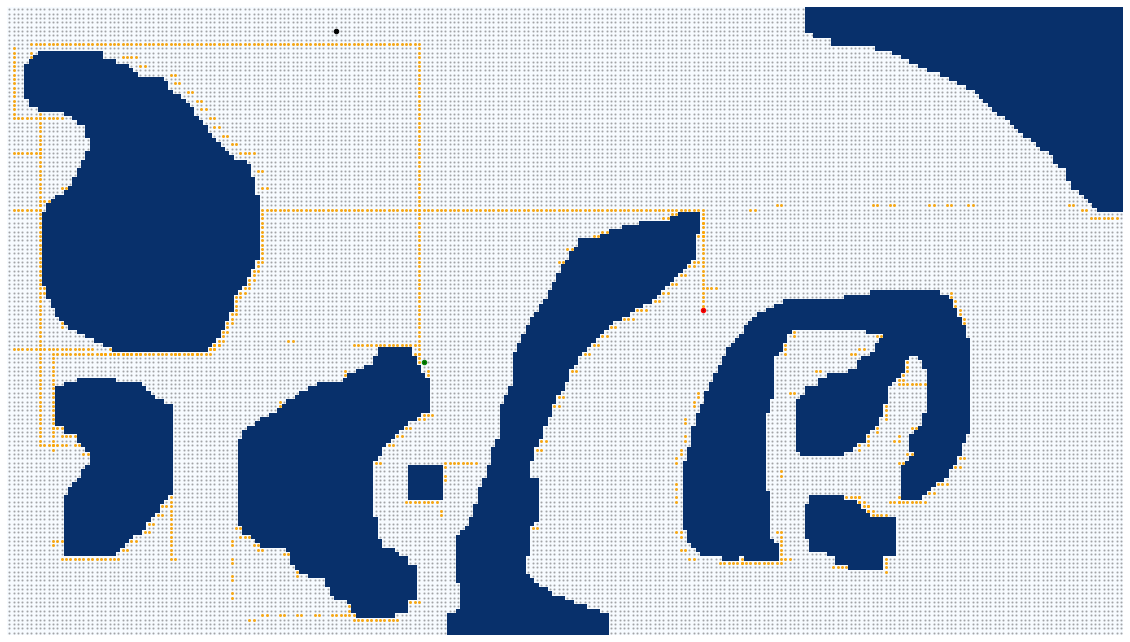

In [6]:
%time single_test(area_maps[16])

In [8]:
for i, area_map in enumerate(area_maps):
    start_point = get_random_coords(area_map, 1)[0]
    center_point = get_random_coords(area_map,1)[0]

    print(f"# Area Map : {i} , area : {(area_map==0).sum()}\nshape : {area_map.shape}, size : {area_map.size}")
    print(f"start_point : {start_point}, center_point: {center_point}")
    print(f"\nISOLATED AREA CHECK TIME")
    %time has_isolated = has_isolated_areas(area_map)
    if has_isolated:
        print("isolated area present, algo won't work")
        print()
        print("-"*42)
        continue

    print(f"\nCOVERAGE PATH GENERATION TIME")
    %time coverage_path , backtrack_paths, backtrack_starts = wavefront_caller(area_map, start_point, center_point)

    print(f"\nREPLACEMENT PATH GENERATION TIME")
    %time replacement_paths = get_replacement_paths_l1(backtrack_paths, area_map)

    print(f"cp len : {len(coverage_path)}, bt len : {bt_len(backtrack_paths)}, rp len : {bt_len(replacement_paths)}")
    print()
    print("-"*42)
    print()
#     input()

del i, area_map, start_point, center_point, has_isolated
del coverage_path, backtrack_paths, backtrack_starts, replacement_paths

# Area Map : 0 , area : 716
shape : (32, 32), size : 1024
start_point : (27, 20), center_point: (1, 10)

ISOLATED AREA CHECK TIME
CPU times: user 12.9 ms, sys: 690 µs, total: 13.6 ms
Wall time: 13.5 ms

COVERAGE PATH GENERATION TIME
CPU times: user 63 ms, sys: 1.46 ms, total: 64.4 ms
Wall time: 66 ms

REPLACEMENT PATH GENERATION TIME
CPU times: user 14 ms, sys: 641 µs, total: 14.7 ms
Wall time: 18.2 ms
cp len : 716, bt len : 987, rp len : 65

------------------------------------------

# Area Map : 1 , area : 689
shape : (32, 32), size : 1024
start_point : (22, 4), center_point: (11, 1)

ISOLATED AREA CHECK TIME
CPU times: user 8.94 ms, sys: 262 µs, total: 9.2 ms
Wall time: 13 ms

COVERAGE PATH GENERATION TIME
CPU times: user 32.8 ms, sys: 922 µs, total: 33.8 ms
Wall time: 36.9 ms

REPLACEMENT PATH GENERATION TIME
CPU times: user 15.8 ms, sys: 695 µs, total: 16.5 ms
Wall time: 17.8 ms
cp len : 689, bt len : 176, rp len : 77

------------------------------------------

# Area Map : 2 , 

CPU times: user 1.73 s, sys: 7.06 ms, total: 1.74 s
Wall time: 1.75 s
cp len : 25866, bt len : 78290, rp len : 1829

------------------------------------------

# Area Map : 17 , area : 36713
shape : (144, 256), size : 36864
start_point : (130, 65), center_point: (70, 36)

ISOLATED AREA CHECK TIME
CPU times: user 600 ms, sys: 2.96 ms, total: 603 ms
Wall time: 607 ms

COVERAGE PATH GENERATION TIME
CPU times: user 1.36 s, sys: 4.9 ms, total: 1.36 s
Wall time: 1.37 s

REPLACEMENT PATH GENERATION TIME
CPU times: user 1.12 s, sys: 3.74 ms, total: 1.13 s
Wall time: 1.13 s
cp len : 36713, bt len : 1745, rp len : 394

------------------------------------------

# Area Map : 18 , area : 24720
shape : (144, 256), size : 36864
start_point : (106, 14), center_point: (44, 49)

ISOLATED AREA CHECK TIME
CPU times: user 314 ms, sys: 2.47 ms, total: 317 ms
Wall time: 318 ms

COVERAGE PATH GENERATION TIME
CPU times: user 1.29 s, sys: 5.56 ms, total: 1.3 s
Wall time: 1.3 s

REPLACEMENT PATH GENERATION TI